In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression, QuantileRegressor
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
import seaborn as sns
import scienceplots
from scipy import stats


In [3]:

df = pd.read_csv('price_reduction_models.csv')
print(df.columns)
#convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

#print the first 5 rows of the datafr

Index(['Model', 'Creator', 'License', 'Context\n Window',
       'Artificial Analysis\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\n USD/1M Tokens', 'Median\n Tokens/s', 'P5\n Tokens/s',
       'P25\n Tokens/s', 'P75\n Tokens/s', 'P95\n Tokens/s',
       'Median\n First Chunk (s)', 'First Answer\n Token (s)',
       'P5\n First Chunk (s)', 'P25\n First Chunk (s)',
       'P75\n First Chunk (s)', 'P95\n First Chunk (s)',
       'Total\n Response (s)', 'Reasoning\n Time (s)', 'Reasoning_TF',
       'Further\n Analysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Latency', 'token/s', 'Chinese', 'Notes',
       'Unnam

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_97683/1656402903.py:150: RuntimeWarning: overflow encountered in power
  plt.fill_between(x_dates, 10**y_lower, 10**y_upper,


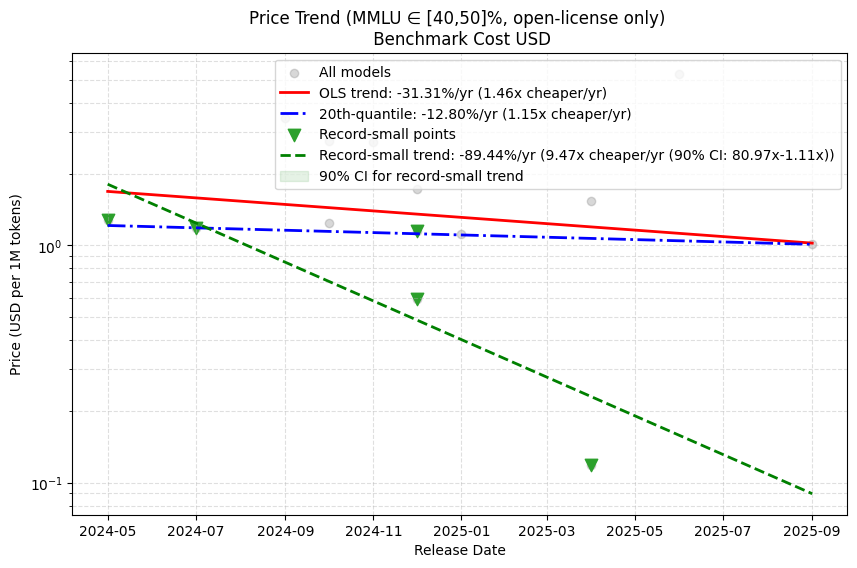

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime
from scipy import stats

def plot_price_trend_by_mmlu(min_mmlu, max_mmlu, open_license_only=False, quantile=0.2, price_col='Output Price\nUSD/1M Tokens',mmlu_col='MMLU-Pro (Reasoning & Knowledge)', show_model_names=False, show_confidence_interval=False):
    """
    Plot price‐per‐1M-token trends for models with MMLU in [min_mmlu, max_mmlu].
    If open_license_only=True, only keep rows where `license_col` contains 'open' (case‐insensitive).
    Assumes `df` is in scope with columns:
      - 'Release Date' (datetime64)
      - 'MMLU-Pro (Reasoning & Knowledge)' (e.g. "75%")
      - price_col (e.g. "$0.50")
      - license_col (e.g. 'License')
    
    Parameters:
      min_mmlu: Minimum MMLU score to include
      max_mmlu: Maximum MMLU score to include
      open_license_only: If True, only include models with open licenses
      quantile: Quantile level for the quantile regression (default: 0.5 for median)
      price_col: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
      show_model_names: If True, displays model names next to record-small points
      show_confidence_interval: If True, shows 90% confidence interval for record-small trend
    """
    # --- column names ---
    # mmlu_col    = 'MMLU-Pro (Reasoning & Knowledge)'
    license_col = 'License'   # ← adjust if your CSV uses a different header

    # 1) Work on a copy
    df_work = df.copy()

    # 2) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%','',regex=False)
                         .astype(float)
    )

    # 3) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]','',regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    # 4) Optionally filter to open‐license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 5) Filter to MMLU range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 6) Drop missing Release Date or price, remove non‐positive prices
    df_sub = df_sub.dropna(subset=['Release Date', price_col])
    df_sub = df_sub[df_sub[price_col] > 0]

    # 7) Sort & compute ordinal date
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 8) Prepare regressions on log10(price)
    X     = df_sub['Date_Ordinal'].values.reshape(-1,1)
    y_log = np.log10(df_sub[price_col].values)

    # overall OLS
    ols = LinearRegression().fit(X, y_log)
    # quantile regression with specified quantile
    qr  = QuantileRegressor(quantile=quantile, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.arange(min_ord, max_ord + 1)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]

    y_ols_log = ols.predict(x_range.reshape(-1,1))
    y_qr_log  = qr.predict(x_range.reshape(-1,1))

    # 10) Compute annualized % growth and price decrease factor
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_factor_ols = 1 / (10**ols.coef_[0])**365
    
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    annual_factor_qr = 1 / (10**qr.coef_[0])**365

    # 11) "Record‐small" = running minima of price
    df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # OLS on those
    X_rec         = record_small['Date_Ordinal'].values.reshape(-1,1)
    y_rec_log     = np.log10(record_small[price_col].values)
    rec_ols       = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
    annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
    
    # Calculate confidence interval for record-small trend if requested
    ci_text = ""
    if show_confidence_interval and len(X_rec) > 2:
        # Get prediction interval for the coefficient
        n = len(X_rec)
        mean_x = np.mean(X_rec)
        t_val = stats.t.ppf(0.95, n-2)  # 90% CI (two-tailed)
        
        # Standard error calculation
        sum_squared_errors = np.sum((y_rec_log - rec_ols.predict(X_rec))**2)
        sum_squared_x_diff = np.sum((X_rec.flatten() - mean_x)**2)
        std_err = np.sqrt(sum_squared_errors / (n-2) / sum_squared_x_diff)
        
        # Confidence interval for slope
        ci_lower = rec_ols.coef_[0] - t_val * std_err
        ci_upper = rec_ols.coef_[0] + t_val * std_err
        
        # Convert to annual factors
        annual_factor_lower = 1 / (10**ci_lower)**365
        annual_factor_upper = 1 / (10**ci_upper)**365
        
        ci_text = f" (90% CI: {annual_factor_lower:.2f}x-{annual_factor_upper:.2f}x)"

    # 12) Plot
    plt.figure(figsize=(10,6))
    # all
    plt.scatter(df_sub['Release Date'], df_sub[price_col],
                color='gray', alpha=0.3, label='All models')
    # OLS trend
    plt.plot(x_dates, 10**y_ols_log, 'r-', lw=2,
             label=f'OLS trend: {annual_pct_ols:.2f}%/yr ({annual_factor_ols:.2f}x cheaper/yr)')
    # specified quantile
    plt.plot(x_dates, 10**y_qr_log, 'b-.', lw=2,
             label=f'{quantile*100:.0f}th-quantile: {annual_pct_qr:.2f}%/yr ({annual_factor_qr:.2f}x cheaper/yr)')
    # record-small points
    plt.scatter(record_small['Release Date'], record_small[price_col],
                color='tab:green', s=80, marker='v',
                label='Record-small points')
    # record-small trend
    plt.plot(x_dates, 10**y_rec_log_pred, 'g--', lw=2,
             label=f'Record-small trend: {annual_pct_rec:.2f}%/yr ({annual_factor_rec:.2f}x cheaper/yr{ci_text})')
    
    # Add confidence interval bands if requested
    if show_confidence_interval and len(X_rec) > 2:
        # Calculate prediction bands
        y_lower = ci_lower * (x_range - min_ord) + rec_ols.intercept_
        y_upper = ci_upper * (x_range - min_ord) + rec_ols.intercept_
        
        plt.fill_between(x_dates, 10**y_lower, 10**y_upper, 
                         color='green', alpha=0.1, 
                         label='90% CI for record-small trend')
    
    # Add model names if requested
    if show_model_names:
        for idx, row in record_small.iterrows():
            plt.annotate(row['Model'], 
                         (row['Release Date'], row[price_col]),
                         xytext=(5, 5), 
                         textcoords='offset points',
                         fontsize=8)

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    lic_label = 'open‐license only' if open_license_only else 'all licenses'
    plt.title(f'Price Trend (MMLU ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}) \n {price_col}')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()


plot_price_trend_by_mmlu(40, 50, open_license_only=True, quantile=0.2, price_col="Benchmark Cost USD", mmlu_col='epoch_gpqa', show_confidence_interval=True)





# plot_price_trend_by_mmlu(10, 30, open_license_only=True, quantile=0.2, price_col="Lowest Blended Price AA", show_model_names=True,show_confidence_interval=True)

# Example usage:
# plot_price_trend_by_mmlu(50, 70, open_license_only=True, quantile=0.2, show_confidence_interval=True)

MMLU 30-50% R² = 0.669
MMLU 50-70% R² = 0.360
MMLU 70-90% R² = nan


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98006/712209039.py:203: RuntimeWarning: overflow encountered in power
  10**y_upper,
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_98006/712209039.py:203: RuntimeWarning: overflow encountered in power
  10**y_upper,
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


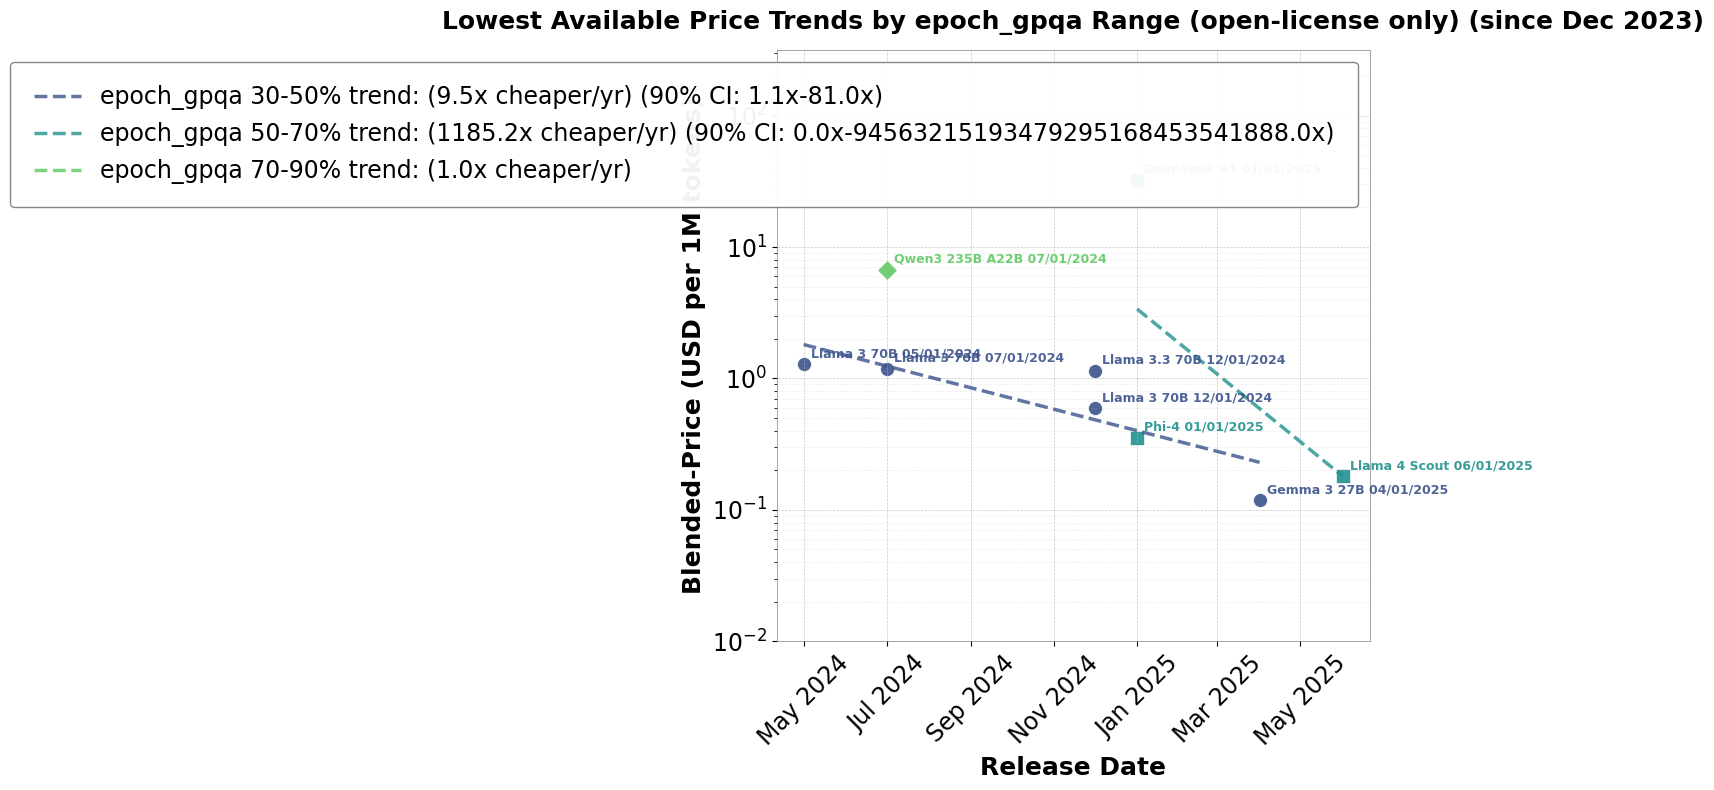

In [16]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
# import scienceplots
# from datetime import datetime
# import numpy as np
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# from scipy import stats


# get predictions at highly skewed
#R^2 regression


def plot_combined_record_small_trends(open_license_only=False, price_col='Lowest Blended Price AA', show_model_names=False, min_date=datetime(2023, 1, 1), confidence_interval=True, include_chinese=None, benchmark_col='MMLU-Pro (Reasoning & Knowledge)', mmlu_ranges=[(30, 50), (50, 70), (70, 90)], include_reasoning_models=True):
    """
    Plot record-small points and their trend lines for specified MMLU ranges 
    on a single graph with enhanced styling. Includes 90% confidence intervals.
    
    Parameters:
      open_license_only: If True, only include models with open licenses
      price_col: Column name for price data (default: 'Lowest Blended Price AA')
      show_model_names: If True, displays model names next to record-small points
      min_date: If provided, only include models released on or after this date (datetime or string)
                Default is January 1, 2024
      confidence_interval: If True, displays 90% confidence intervals for trend lines
      include_chinese: Filter for Chinese models - if True, only include Chinese models; 
                      if False, exclude Chinese models; if None, include all models
      benchmark_col: Column name for the benchmark to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
      mmlu_ranges: List of tuples defining MMLU score ranges (default: [(30, 50), (50, 70), (70, 90)])
      include_reasoning_models: If True, include reasoning models; if False, exclude reasoning models (default: True)
    """
    # Set up the styling with standard matplotlib font
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure with specific dimensions
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    
    # Set background to white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Use provided MMLU ranges with custom palette
    palette = sns.color_palette("viridis", n_colors=len(mmlu_ranges))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # Extended list of markers
    
    # --- column names ---
    mmlu_col = benchmark_col
    license_col = 'License'
    chinese_col = 'Chinese'
    reasoning_col = 'Reasoning_TF'
    
    # Store all data for setting axis limits
    all_dates = []
    all_prices = []
    
    for i, (min_mmlu, max_mmlu) in enumerate(mmlu_ranges):
        color = palette[i]
        marker = markers[i % len(markers)]  # Cycle through markers if we have more ranges than markers
        
        # 1) Work on a copy
        df_work = df.copy()

        # 2) Convert MMLU "XX%" → float
        df_work[mmlu_col] = (
            df_work[mmlu_col].astype(str)
                             .str.replace('%','',regex=False)
                             .astype(float)
        )

        # 3) Convert price "$X,XXX" → float
        df_work[price_col] = (
            df_work[price_col].astype(str)
                             .str.replace('[$,]','',regex=True)
        )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

        # 4) Optionally filter to open‐license only
        if open_license_only:
            df_work = df_work[
                df_work[license_col].notna() &
                df_work[license_col].str.contains('open', case=False, na=False)
            ]
            
        # 4b) Filter by date if min_date is provided
        if min_date is not None:
            if isinstance(min_date, str):
                min_date = pd.to_datetime(min_date)
            df_work = df_work[df_work['Release Date'] >= min_date]
            
        # 4c) Filter by Chinese models if specified
        if include_chinese is not None:
            if include_chinese:
                # Only include Chinese models (where Chinese column is TRUE)
                df_work = df_work[df_work[chinese_col] == True]
            else:
                # Exclude Chinese models (where Chinese column is TRUE)
                df_work = df_work[(df_work[chinese_col] != True) | (df_work[chinese_col].isna())]
                
        # 4d) Filter by reasoning models if specified
        if not include_reasoning_models:
            # Exclude reasoning models (where Reasoning_TF column is TRUE)
            df_work = df_work[(df_work[reasoning_col] != True) | (df_work[reasoning_col].isna())]

        # 5) Filter to MMLU range
        df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

        # 6) Drop missing Release Date or price, remove non‐positive prices
        df_sub = df_sub.dropna(subset=['Release Date', price_col])
        df_sub = df_sub[df_sub[price_col] > 0]

        # Skip if no data
        if len(df_sub) == 0:
            continue

        # 7) Sort & compute ordinal date
        df_sub = df_sub.sort_values('Release Date')
        df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

        # 8) "Record‐small" = running minima of price
        df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
        record_small = df_sub[df_sub['Is_Record_Small']].copy()
        
        # Skip if no record small points
        if len(record_small) == 0:
            continue

        # 9) Linear regression on record small points (log scale)
        X_rec = record_small['Date_Ordinal'].values.reshape(-1,1)
        y_rec_log = np.log10(record_small[price_col].values)
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        
        # Calculate R^2 value
        r_squared = rec_ols.score(X_rec, y_rec_log)
        print(f"MMLU {min_mmlu}-{max_mmlu}% R² = {r_squared:.3f}")
        
        # 10) Create prediction line
        min_ord, max_ord = record_small['Date_Ordinal'].min(), record_small['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
        
        # 11) Calculate annual decrease rate
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        annual_factor_rec = 1 / (10**rec_ols.coef_[0])**365
        
        # Calculate 90% confidence intervals for the slope if requested
        ci_label = ""
        n = len(X_rec)
        if confidence_interval and n > 2:  # Need at least 3 points for confidence interval
            # Calculate residuals and standard error
            y_pred = rec_ols.predict(X_rec)
            residuals = y_rec_log - y_pred
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X_rec - np.mean(X_rec))**2))
            
            # t-value for 90% confidence interval (two-tailed)
            t_val = stats.t.ppf(0.95, n - 2)
            
            # Confidence interval for slope
            ci_lower = rec_ols.coef_[0] - t_val * se
            ci_upper = rec_ols.coef_[0] + t_val * se
            
            # Convert to annual factors
            annual_factor_lower = 1 / (10**ci_upper)**365  # Note: Upper CI of negative slope gives lower factor
            annual_factor_upper = 1 / (10**ci_lower)**365  # Note: Lower CI of negative slope gives upper factor
            
            ci_label = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"

        # 12) Plot record small points with enhanced styling
        sns.scatterplot(
            x=record_small['Release Date'], 
            y=record_small[price_col],
            color=color, 
            s=100,  # Slightly larger points
            marker=marker, 
            alpha=0.9,
            edgecolor='white',
            linewidth=0.5,
            ax=ax
        )
        
        # 13) Plot trend line with enhanced styling
        ax.plot(
            x_dates, 
            10**y_rec_log_pred, 
            color=color, 
            linestyle='--', 
            linewidth=2.5,
            alpha=0.8,
            label=f'{benchmark_col.split(" ")[0]} {min_mmlu}-{max_mmlu}% trend: ({annual_factor_rec:.1f}x cheaper/yr){ci_label}'
        )
        
        # Plot confidence intervals if we have enough data points and confidence_interval is True
        if confidence_interval and n > 2:
            y_lower = ci_lower * x_range + rec_ols.intercept_
            y_upper = ci_upper * x_range + rec_ols.intercept_
            
            ax.fill_between(
                x_dates,
                10**y_lower,
                10**y_upper,
                color=color,
                alpha=0.1
            )
        
        # 14) Add model names if requested
        if show_model_names:
            for idx, row in record_small.iterrows():
                ax.annotate(
                    row['Model'], 
                    (row['Release Date'], row[price_col]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9,
                    color=color,
                    fontweight='bold',
                    alpha=0.9
                )
        
        # Store data for axis limits
        all_dates.extend(record_small['Release Date'].tolist())
        all_prices.extend(record_small[price_col].tolist())
    
    # 15) Enhanced formatting
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=18, fontweight='bold')
    ax.set_ylabel('Blended-Price (USD per 1M tokens)', fontsize=18, fontweight='bold')
    
    # Format date axis
    date_formatter = DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)
    
    # Title with styling
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    date_filter = f" (since {min_date.strftime('%b %Y')})" if min_date is not None else ""
    chinese_filter = " (Chinese models only)" if include_chinese is True else " (non-Chinese models)" if include_chinese is False else ""
    reasoning_filter = " (non-reasoning models)" if not include_reasoning_models else ""
    benchmark_name = benchmark_col.split(" ")[0]  # Extract first part of benchmark name for title
    ax.set_title(f'Lowest Available Price Trends by {benchmark_name} Range ({lic_label}){date_filter}{chinese_filter}{reasoning_filter}',     fontsize=18, fontweight='bold', pad=15)
    
# \n{price_col}


    # Grid styling
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
    # Legend styling
    legend = ax.legend(
        loc='upper right', 
        fontsize=17,
        frameon=True,
        fancybox=True,
        framealpha=0.95,
        edgecolor='gray',
        borderpad=1
    )
    
    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=17)
    
    # Add a subtle border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)
    
    plt.tight_layout()
    plt.ylim(10**-2,10**2.5)
    plt.show()

# Usage examples:
# For all licenses:
# plot_combined_record_small_trends(open_license_only=False, price_col="Lowest Blended Price AA", min_date=datetime(2023, 12, 1), confidence_interval=True, show_model_names=True)

# For open licenses only with model names:
plot_combined_record_small_trends(open_license_only=True, price_col="Benchmark Cost USD", confidence_interval=True, min_date=datetime(2023, 12, 1), benchmark_col='epoch_gpqa', show_model_names=True, include_reasoning_models=True, mmlu_ranges=[(30, 50), (50, 70), (70, 90)])
# # For Chinese models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=True)

# # For non-Chinese models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_chinese=False)

# # For non-reasoning models only:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", include_reasoning_models=False)

# # Example with custom MMLU ranges:
# plot_combined_record_small_trends(open_license_only=True, price_col="Lowest Blended Price AA", mmlu_ranges=[(20, 40), (40, 60), (60, 80), (80, 95)])



#         'GPQA Diamond (Scientific Reasoning)',
# #        'Humanity's Last Exam (Reasoning & Knowledge)',
# #        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
# #        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
# #        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',

# Model Size

In [5]:

def plot_params_small_trend_by_mmlu(min_mmlu, max_mmlu, open_license_only=False, benchmark_name='MMLU-Pro (Reasoning & Knowledge)', use_active_params=False, show_model_names=False):
    """
    Plot number-of-parameters (in billions) vs. release date for models
    with benchmark score ∈ [min_mmlu, max_mmlu], and highlight the record-small trend
    (running minima of model size).
    
    Parameters:
    - min_mmlu, max_mmlu: numeric bounds on benchmark score (%)
    - open_license_only: if True, only include rows where 'License' contains 'open'
    - benchmark_name: name of the benchmark column to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - use_active_params: if True, use 'Active Parameters' column instead of 'Parameters'
    - show_model_names: if True, display model names next to record-small points
    
    Assumes `df` is in scope with columns:
      - 'Release Date' (datetime64)
      - benchmark_name (e.g. '75%')
      - 'Parameters' or 'Active Parameters' (absolute count)
      - 'License' (string)
    """
    # column names
    mmlu_col    = benchmark_name
    param_col   = 'Active Parameters' if use_active_params else 'Parameters'  # choose parameter column
    license_col = 'License'             # adjust if needed

    # work on a copy
    df_work = df.copy()

    # 1) Convert benchmark score "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )

    # 2) Convert parameter counts → numeric; scale to billions
    df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')
    df_work['Params_B'] = df_work[param_col]

    # 3) Optionally filter to open-licensed models
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 4) Filter to benchmark score range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 5) Drop missing dates or sizes; remove non-positive sizes
    df_sub = df_sub.dropna(subset=['Release Date', 'Params_B'])
    df_sub = df_sub[df_sub['Params_B'] > 0]

    # 6) Sort & compute ordinal dates
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Check if we have enough data points to proceed
    if len(df_sub) < 1:
        print(f"Warning: No data points found for the specified criteria. "
              f"MMLU range: [{min_mmlu}, {max_mmlu}], Open license only: {open_license_only}, "
              f"Using {param_col}")
        return
    
    # 7) Prepare X, y (log10 of Params_B)
    X     = df_sub['Date_Ordinal'].values.reshape(-1, 1)
    y_log = np.log10(df_sub['Params_B'].values)

    # 8) Fit overall OLS & median QuantileRegressor
    ols = LinearRegression().fit(X, y_log)
    qr  = QuantileRegressor(quantile=0.5, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    lo, hi    = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range   = np.arange(lo, hi + 1)
    x_dates   = [datetime.fromordinal(int(d)) for d in x_range]
    y_ols_log = ols.predict(x_range.reshape(-1, 1))
    y_qr_log  = qr.predict(x_range.reshape(-1, 1))

    # 10) Annualized growth rates
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100
    
    # Calculate factor decreases (for negative percentages)
    factor_ols = 1 / (1 + annual_pct_ols/100) if annual_pct_ols < 0 else None
    factor_qr = 1 / (1 + annual_pct_qr/100) if annual_pct_qr < 0 else None

    # 11) Identify record-small points (running minima of size)
    df_sub['Is_Record_Small'] = df_sub['Params_B'].cummin() == df_sub['Params_B']
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # 12) Fit OLS on record-small points
    X_rec = record_small['Date_Ordinal'].values.reshape(-1, 1)
    y_rec_log = np.log10(record_small['Params_B'].values)
    
    # Only proceed with record small trend if we have at least one data point
    if len(record_small) >= 1:
        rec_ols = LinearRegression().fit(X_rec, y_rec_log)
        y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))
        annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100
        factor_rec = 1 / (1 + annual_pct_rec/100) if annual_pct_rec < 0 else None
    else:
        rec_ols = None
        y_rec_log_pred = None
        annual_pct_rec = None
        factor_rec = None

    # 13) Plot
    plt.figure(figsize=(10, 6))

    # a) All models
    plt.scatter(
        df_sub['Release Date'], df_sub['Params_B'],
        color='gray', alpha=0.3, label='All models'
    )
    # b) Overall OLS trend
    ols_label = f'OLS trend: {annual_pct_ols:.2f}%/yr'
    if factor_ols:
        ols_label += f' ({factor_ols:.2f}× decrease/yr)'
    plt.plot(
        x_dates, 10**y_ols_log,
        'r-', lw=2, label=ols_label
    )
    # c) Median quantile trend
    qr_label = f'50th-quantile trend: {annual_pct_qr:.2f}%/yr'
    if factor_qr:
        qr_label += f' ({factor_qr:.2f}× decrease/yr)'
    plt.plot(
        x_dates, 10**y_qr_log,
        'b-.', lw=2, label=qr_label
    )
    
    # d & e) Only plot record small trend if we have data
    if len(record_small) >= 1:
        # d) Record-small points
        plt.scatter(
            record_small['Release Date'], record_small['Params_B'],
            color='tab:green', s=80, marker='v',
            label='Record-small points'
        )
        
        # Add model names if requested
        if show_model_names and 'Model' in record_small.columns:
            for i, row in record_small.iterrows():
                plt.annotate(
                    row['Model'],
                    (row['Release Date'], row['Params_B']),
                    xytext=(5, 0),
                    textcoords='offset points',
                    fontsize=8,
                    va='center'
                )
                
        # e) Record-small OLS trend
        if rec_ols is not None:
            rec_label = f'Record-small trend: {annual_pct_rec:.2f}%/yr'
            if factor_rec:
                rec_label += f' ({factor_rec:.2f}× decrease/yr)'
            plt.plot(
                x_dates, 10**y_rec_log_pred,
                'g--', lw=2,
                label=rec_label
            )

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Parameters (billion)')
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    param_type = 'Active Parameters' if use_active_params else 'Parameters'
    benchmark_short = benchmark_name.split(' ')[0]
    plt.title(f'Model-size Trend ({benchmark_short} ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}, {param_type})')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()


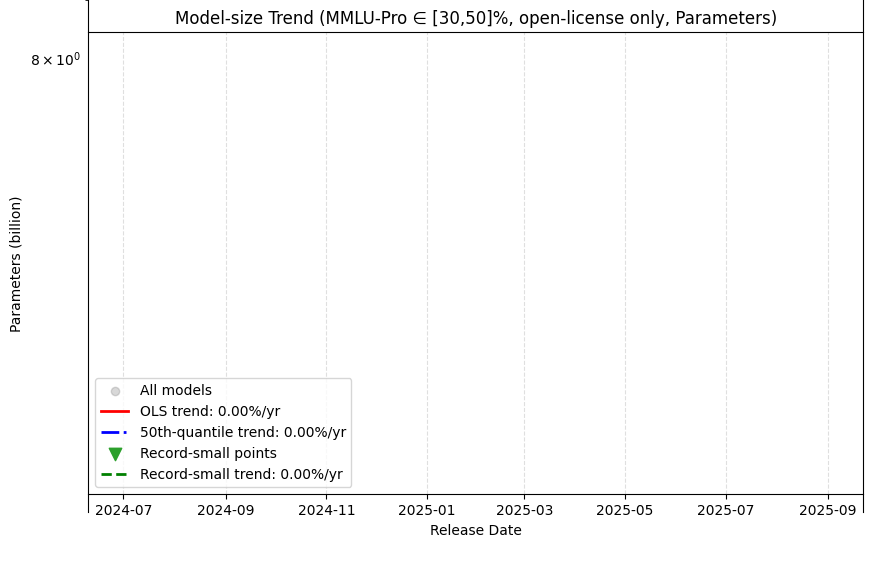

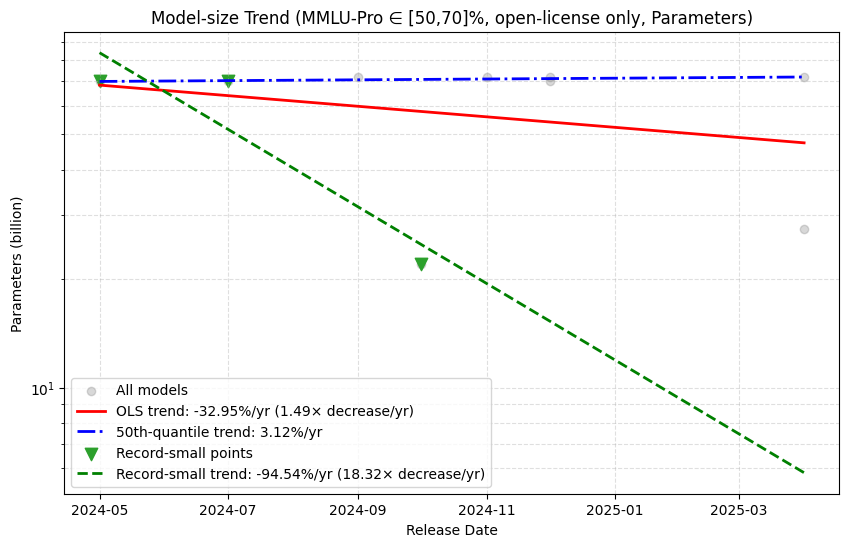

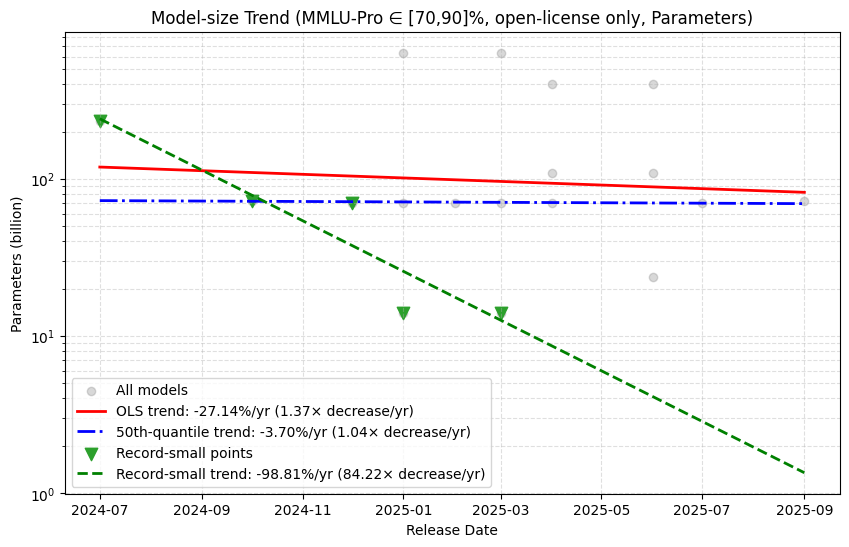

In [6]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=False)
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=False)
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=False)

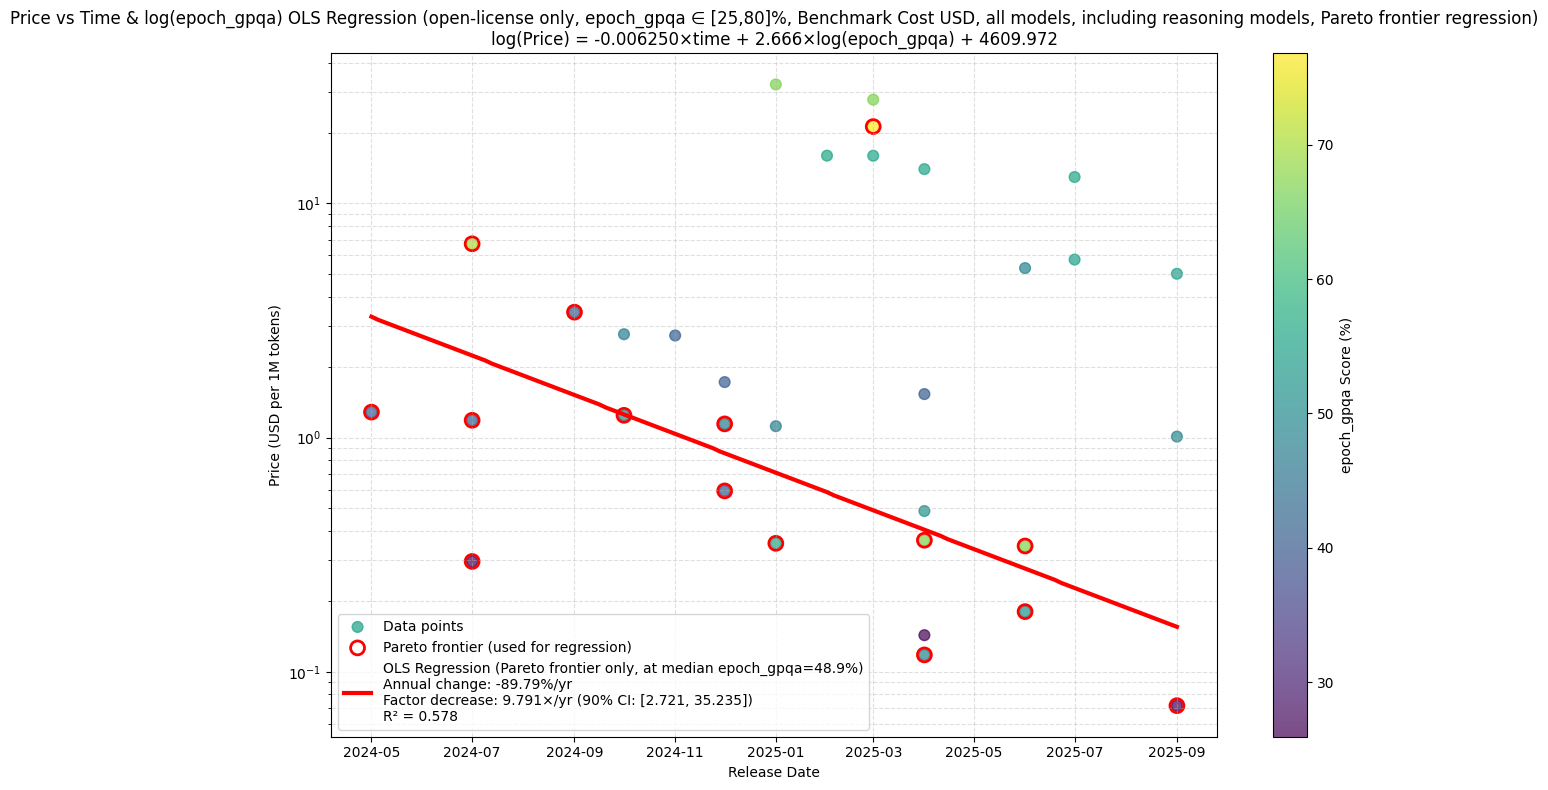


Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.006250×time + 2.666×log(epoch_gpqa) + 4609.972
R² score: 0.5780

Time coefficient (alpha): -0.006250
Annual percentage change: -89.79%/yr
Annual factor decrease: 9.791×/yr
90% CI for factor decrease: [2.721, 35.235]
log(epoch_gpqa) coefficient (beta): 2.666
Intercept (c): 4609.972

Data points used for regression: 15
Data points displayed: 32


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
from datetime import datetime
from scipy import stats

def plot_price_mmlu_regression(
    df,
    open_license_only=False,
    min_mmlu=40,
    max_mmlu=70,
    price_column='Output Price\nUSD/1M Tokens',
    exclude_dominated=False,
    benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
    exclude_reasoning=False,
    use_huber=False,
    huber_epsilon=1.35,
    huber_max_iter=100,
    pareto_frontier_only=False
):
    """
    Plot log(Price) = alpha*time + beta*log(MMLU Pro) + c regression

    Parameters:
    - df: DataFrame with the model data
    - open_license_only: If True, only include models with open licenses
    - min_mmlu: Minimum MMLU score to include (default: 40)
    - max_mmlu: Maximum MMLU score to include (default: 70)
    - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    - benchmark_col: Column name for benchmark data (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - exclude_reasoning: If True, exclude models with Reasoning_TF = True
    - use_huber: If True, use Huber regression instead of ordinary least squares
    - huber_epsilon: Epsilon parameter for HuberRegressor (default: 1.35)
    - huber_max_iter: Maximum iterations for HuberRegressor (default: 100)
    - pareto_frontier_only: If True, only use Pareto frontier models for the regression

    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    mmlu_col = benchmark_col
    price_col = price_column
    license_col = 'License'
    reasoning_col = 'Reasoning_TF'

    # Work on a copy
    df_work = df.copy()

    # 1) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )

    # 2) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]', '', regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    # 3) Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 4) Optionally filter out reasoning models
    if exclude_reasoning and reasoning_col in df_work.columns:
        df_work = df_work[df_work[reasoning_col] != True]

    # 5) Filter to rows with all necessary data
    df_sub = df_work.dropna(subset=['Release Date', price_col, mmlu_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[mmlu_col] > 0)]

    # 6) Filter by MMLU range
    df_sub = df_sub[(df_sub[mmlu_col] >= min_mmlu) & (df_sub[mmlu_col] <= max_mmlu)]

    # 7) Optionally filter out Pareto dominated models (this affects data display)
    df_sub_display = df_sub.copy()  # Keep original for display
    if exclude_dominated:
        df_sub_display = df_sub_display.sort_values('Release Date')
        non_dominated = []

        for i, row in df_sub_display.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub_display.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal MMLU score AND
                # 2. Lower or equal price
                if (prev_row[mmlu_col] >= row[mmlu_col] and 
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[mmlu_col] > row[mmlu_col] or prev_row[price_col] < row[price_col])):
                    dominated = True
                    break

            if not dominated:
                non_dominated.append(i)

                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub_display.loc[j]
                    if not (row[mmlu_col] >= prev_row[mmlu_col] and 
                           row[price_col] <= prev_row[price_col] and
                           (row[mmlu_col] > prev_row[mmlu_col] or row[price_col] < prev_row[price_col])):
                        new_non_dominated.append(j)

                non_dominated = new_non_dominated + [i]

        df_sub_display = df_sub_display.loc[non_dominated]

    # 8) For regression, decide which data to use
    if pareto_frontier_only:
        # Identify Pareto frontier models at each point in time
        df_regression = df_sub.sort_values('Release Date').copy()
        pareto_indices = []
        
        for date in df_regression['Release Date'].unique():
            # Get all models available at this date
            available_models = df_regression[df_regression['Release Date'] <= date].copy()
            
            # Find Pareto frontier at this date
            available_models = available_models.sort_values([price_col, mmlu_col])
            frontier_indices = []
            
            for i, row in available_models.iterrows():
                # Check if this model is on the Pareto frontier
                dominated = False
                for j in frontier_indices:
                    frontier_row = available_models.loc[j]
                    # A model is dominated if there exists another model with:
                    # 1. Better or equal MMLU score AND
                    # 2. Lower or equal price
                    # AND at least one is strictly better
                    if (frontier_row[mmlu_col] >= row[mmlu_col] and 
                        frontier_row[price_col] <= row[price_col] and
                        (frontier_row[mmlu_col] > row[mmlu_col] or frontier_row[price_col] < row[price_col])):
                        dominated = True
                        break
                
                if not dominated:
                    frontier_indices.append(i)
                    # Remove any previously added models that this one dominates
                    new_frontier_indices = []
                    for j in frontier_indices[:-1]:
                        frontier_row = available_models.loc[j]
                        if not (row[mmlu_col] >= frontier_row[mmlu_col] and 
                               row[price_col] <= frontier_row[price_col] and
                               (row[mmlu_col] > frontier_row[mmlu_col] or row[price_col] < frontier_row[price_col])):
                            new_frontier_indices.append(j)
                    frontier_indices = new_frontier_indices + [i]
            
            # Add models released exactly on this date that are on the frontier
            current_date_models = df_regression[df_regression['Release Date'] == date]
            for i, row in current_date_models.iterrows():
                if i in frontier_indices:
                    pareto_indices.append(i)
        
        # Remove duplicates and use for regression
        pareto_indices = list(set(pareto_indices))
        df_regression = df_regression.loc[pareto_indices]
    else:
        df_regression = df_sub.copy()

    if len(df_regression) < 3:
        print(f"Warning: Only {len(df_regression)} data points available for regression. Need at least 3.")
        return None, None, None

    # 9) Prepare variables for regression
    df_regression = df_regression.sort_values('Release Date').copy()
    df_regression['Date_Ordinal'] = df_regression['Release Date'].map(datetime.toordinal)

    # Features: time and log(MMLU)
    X = np.column_stack([
        df_regression['Date_Ordinal'].values,
        np.log(df_regression[mmlu_col].values)
    ])

    # Target: log(Price)
    y = np.log(df_regression[price_col].values)

    # 10) Fit regression (OLS or Huber)
    if use_huber:
        model = HuberRegressor(epsilon=huber_epsilon, max_iter=huber_max_iter).fit(X, y)
        alpha, beta = model.coef_
        c = model.intercept_
        # HuberRegressor does not provide R^2 directly, so we compute it manually
        y_pred = model.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        reg_type = "Huber"
    else:
        model = LinearRegression().fit(X, y)
        alpha, beta = model.coef_
        c = model.intercept_
        y_pred = model.predict(X)
        r2 = model.score(X, y)
        reg_type = "OLS"

    # 11) Calculate annual decrease rates
    # alpha is change in log(price) per day, so annual change is alpha * 365
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)

    # Express as factor decrease if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_per_year = 1 / factor_change_per_year
    else:
        factor_decrease_per_year = None

    # 12) Calculate confidence intervals for the time coefficient (only for OLS)
    if not use_huber:
        n = len(df_regression)
        p = 2  # number of predictors (time and log(MMLU))
        residuals = y - y_pred
        mse = np.sum(residuals**2) / (n - p - 1)

        # Calculate variance-covariance matrix
        X_mean_centered = X - np.mean(X, axis=0)
        cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse

        # Standard error for alpha (time coefficient)
        se_alpha = np.sqrt(cov_matrix[0, 0])
        se_annual = se_alpha * 365  # Standard error for annual coefficient

        # t-statistic for 90% confidence interval
        t_stat = stats.t.ppf(0.95, n - p - 1)

        # Confidence interval for annual log change
        annual_log_change_lower = annual_log_change - t_stat * se_annual
        annual_log_change_upper = annual_log_change + t_stat * se_annual

        # Convert to factor change confidence interval
        factor_change_lower = np.exp(annual_log_change_lower)
        factor_change_upper = np.exp(annual_log_change_upper)

        # Express as factor decrease for confidence interval if price is decreasing
        if factor_change_per_year < 1:
            factor_decrease_lower = 1 / factor_change_upper
            factor_decrease_upper = 1 / factor_change_lower
        else:
            factor_decrease_lower = None
            factor_decrease_upper = None
    else:
        # HuberRegressor does not provide standard errors/confidence intervals
        factor_change_lower = None
        factor_change_upper = None
        factor_decrease_lower = None
        factor_decrease_upper = None

    # 13) Generate predictions for plotting
    min_ord, max_ord = df_regression['Date_Ordinal'].min(), df_regression['Date_Ordinal'].max()
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]

    # For visualization, we'll show the trend at median MMLU value
    median_mmlu = df_regression[mmlu_col].median()
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), np.log(median_mmlu))
    ])
    y_pred_plot = model.predict(X_pred)

    # 14) Plot results
    plt.figure(figsize=(12, 8))

    # Color points by MMLU score for better visualization (use display data)
    scatter = plt.scatter(
        df_sub_display['Release Date'], 
        df_sub_display[price_col],
        c=df_sub_display[mmlu_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )

    # If using Pareto frontier for regression, highlight those points
    if pareto_frontier_only:
        plt.scatter(
            df_regression['Release Date'], 
            df_regression[price_col],
            facecolors='none',
            edgecolors='red',
            s=100,
            linewidth=2,
            label='Pareto frontier (used for regression)'
        )

    # Add colorbar for MMLU scores
    cbar = plt.colorbar(scatter)
    benchmark_name = benchmark_col.split(' (')[0]  # Extract the main part of the benchmark name
    cbar.set_label(f'{benchmark_name} Score (%)')

    # Plot regression line (at median MMLU)
    data_source = "Pareto frontier only" if pareto_frontier_only else "all data"
    if factor_decrease_per_year:
        regression_label = (f'{reg_type} Regression ({data_source}, at median {benchmark_name}={median_mmlu:.1f}%)\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor decrease: {factor_decrease_per_year:.3f}×/yr'
                           + (f' (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])' if factor_decrease_lower is not None else '') +
                           f'\nR² = {r2:.3f}')
    else:
        regression_label = (f'{reg_type} Regression ({data_source}, at median {benchmark_name}={median_mmlu:.1f}%)\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor change: {factor_change_per_year:.3f}×/yr'
                           + (f' (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])' if factor_change_lower is not None else '') +
                           f'\nR² = {r2:.3f}')

    plt.plot(x_dates, np.exp(y_pred_plot), 'r-', lw=3, label=regression_label)

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')

    lic_label = 'open-license only' if open_license_only else 'all licenses'
    mmlu_range = f"{benchmark_name} ∈ [{min_mmlu},{max_mmlu}]%"
    price_type = price_col.replace('\n', ' ')
    pareto_label = "non-dominated models only" if exclude_dominated else "all models"
    reasoning_label = "excluding reasoning models" if exclude_reasoning else "including reasoning models"
    frontier_label = "Pareto frontier regression" if pareto_frontier_only else "standard regression"
    
    plt.title(f'Price vs Time & log({benchmark_name}) {reg_type} Regression ({lic_label}, {mmlu_range}, {price_type}, {pareto_label}, {reasoning_label}, {frontier_label})\n'
              f'log(Price) = {alpha:.6f}×time + {beta:.3f}×log({benchmark_name}) + {c:.3f}')

    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"\nRegression Results ({reg_type}):")
    print(f"Data used: {data_source}")
    print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×log({benchmark_name}) + {c:.3f}")
    print(f"R² score: {r2:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")

    if factor_decrease_per_year:
        print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
        if factor_decrease_lower is not None:
            print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
    else:
        print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
        if factor_change_lower is not None:
            print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")

    print(f"log({benchmark_name}) coefficient (beta): {beta:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used for regression: {len(df_regression)}")
    print(f"Data points displayed: {len(df_sub_display)}")

    return model, df_regression, {
        'alpha': alpha,
        'beta': beta, 
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
        'factor_change_ci_lower': factor_change_lower,
        'factor_change_ci_upper': factor_change_upper,
        'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
        'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
        'r2_score': r2,
        'regression_type': reg_type,
        'pareto_frontier_only': pareto_frontier_only
    }

# Index(['Model', 'Creator', 'License', 'Context\nWindow',
#        'Artificial Analysis\nIntelligence Index',
#        'MMLU-Pro (Reasoning & Knowledge)',
#        'GPQA Diamond (Scientific Reasoning)',
#        'Humanity's Last Exam (Reasoning & Knowledge)',
#        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
#        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
#        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
#        'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
#        'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
#        'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
#        'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
#        'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
#        'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
#        'Further\nAnalysis', 'Release Date', 'Parameters',
#        'Known Active Parameters', 'Lowest Output Price Found AA',
#        'Lowest Input Price AA', 'Lowest Blended Price AA', 'Latency',
#        'token/s', 'Chinese', 'Notes', 'input_tokens_epoch_gpqa',
#        'outpur_tokens_epoch_gpqa', 'epoch_gpqa', 'price input lowest',
#        'price output lowest', 'total price lowest'],
#       dtype='object')


# Lowest Output Price Found AA
# Lowest Input Price AA

    # benchmark1_col="MMLU-Pro (Reasoning & Knowledge)", 
    # benchmark2_col="GPQA Diamond (Scientific Reasoning)",
    # benchmark3_col="LiveCodeBench (Coding)",

# Example usage:
# Assuming df is loaded with your data
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Output Price Found AA", exclude_dominated=False)
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Input Price AA", exclude_dominated=False)
model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Benchmark Cost USD", 
exclude_dominated=False, benchmark_col="epoch_gpqa", min_mmlu=25, max_mmlu=80, exclude_reasoning=False, use_huber=False, pareto_frontier_only=True)

# Residualized Form Not Needed

In [31]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression, HuberRegressor
# from sklearn.preprocessing import SplineTransformer
# from datetime import datetime
# from scipy import stats

# def plot_price_mmlu_regression(
#     df,
#     open_license_only=False,
#     min_mmlu=40,
#     max_mmlu=70,
#     price_column='Output Price\nUSD/1M Tokens',
#     exclude_dominated=False,
#     benchmark_col='MMLU-Pro (Reasoning & Knowledge)',
#     exclude_reasoning=False,
#     use_huber=False,
#     huber_epsilon=1.35,
#     huber_max_iter=100,
#     pareto_frontier_only=False,
#     residualize_benchmark=False,
#     residualization_method='linear',
#     spline_n_knots=3,
#     spline_degree=3
# ):
#     """
#     Plot log(Price) = alpha*time + beta*log(MMLU Pro) + c regression

#     Parameters:
#     - df: DataFrame with the model data
#     - open_license_only: If True, only include models with open licenses
#     - min_mmlu: Minimum MMLU score to include (default: 40)
#     - max_mmlu: Maximum MMLU score to include (default: 70)
#     - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
#     - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
#     - benchmark_col: Column name for benchmark data (default: 'MMLU-Pro (Reasoning & Knowledge)')
#     - exclude_reasoning: If True, exclude models with Reasoning_TF = True
#     - use_huber: If True, use Huber regression instead of ordinary least squares
#     - huber_epsilon: Epsilon parameter for HuberRegressor (default: 1.35)
#     - huber_max_iter: Maximum iterations for HuberRegressor (default: 100)
#     - pareto_frontier_only: If True, only use Pareto frontier models for the regression
#     - residualize_benchmark: If True, residualize benchmark scores against time to handle multicollinearity
#     - residualization_method: Method for residualizing ('linear', 'spline', 'categorical') (default: 'linear')
#     - spline_n_knots: Number of knots for spline regression (default: 3)
#     - spline_degree: Degree of spline regression (default: 3)

#     Returns fitted model coefficients and annual decrease rates
#     """
#     # Column names
#     mmlu_col = benchmark_col
#     price_col = price_column
#     license_col = 'License'
#     reasoning_col = 'Reasoning_TF'

#     # Work on a copy
#     df_work = df.copy()

#     # 1) Convert MMLU "XX%" → float
#     df_work[mmlu_col] = (
#         df_work[mmlu_col].astype(str)
#                          .str.replace('%', '', regex=False)
#                          .astype(float)
#     )

#     # 2) Convert price "$X,XXX" → float
#     df_work[price_col] = (
#         df_work[price_col].astype(str)
#                          .str.replace('[$,]', '', regex=True)
#     )
#     df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

#     # 3) Optionally filter to open-license only
#     if open_license_only:
#         df_work = df_work[
#             df_work[license_col].notna() &
#             df_work[license_col].str.contains('open', case=False, na=False)
#         ]

#     # 4) Optionally filter out reasoning models
#     if exclude_reasoning and reasoning_col in df_work.columns:
#         df_work = df_work[df_work[reasoning_col] != True]

#     # 5) Filter to rows with all necessary data
#     df_sub = df_work.dropna(subset=['Release Date', price_col, mmlu_col])
#     df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[mmlu_col] > 0)]

#     # 6) Filter by MMLU range
#     df_sub = df_sub[(df_sub[mmlu_col] >= min_mmlu) & (df_sub[mmlu_col] <= max_mmlu)]

#     # 7) Optionally filter out Pareto dominated models (this affects data display)
#     df_sub_display = df_sub.copy()  # Keep original for display
#     if exclude_dominated:
#         df_sub_display = df_sub_display.sort_values('Release Date')
#         non_dominated = []

#         for i, row in df_sub_display.iterrows():
#             # Check if this model is dominated by any previous model
#             dominated = False
#             for j in non_dominated:
#                 prev_row = df_sub_display.loc[j]
#                 # A model is dominated if there exists a previous model with:
#                 # 1. Better or equal MMLU score AND
#                 # 2. Lower or equal price
#                 if (prev_row[mmlu_col] >= row[mmlu_col] and 
#                     prev_row[price_col] <= row[price_col] and
#                     (prev_row[mmlu_col] > row[mmlu_col] or prev_row[price_col] < row[price_col])):
#                     dominated = True
#                     break

#             if not dominated:
#                 non_dominated.append(i)

#                 # Also remove any previously added models that this one dominates
#                 new_non_dominated = []
#                 for j in non_dominated[:-1]:  # All except the one we just added
#                     prev_row = df_sub_display.loc[j]
#                     if not (row[mmlu_col] >= prev_row[mmlu_col] and 
#                            row[price_col] <= prev_row[price_col] and
#                            (row[mmlu_col] > prev_row[mmlu_col] or row[price_col] < prev_row[price_col])):
#                         new_non_dominated.append(j)

#                 non_dominated = new_non_dominated + [i]

#         df_sub_display = df_sub_display.loc[non_dominated]

#     # 8) For regression, decide which data to use
#     if pareto_frontier_only:
#         # Identify Pareto frontier models at each point in time
#         df_regression = df_sub.sort_values('Release Date').copy()
#         pareto_indices = []
        
#         for date in df_regression['Release Date'].unique():
#             # Get all models available at this date
#             available_models = df_regression[df_regression['Release Date'] <= date].copy()
            
#             # Find Pareto frontier at this date
#             available_models = available_models.sort_values([price_col, mmlu_col])
#             frontier_indices = []
            
#             for i, row in available_models.iterrows():
#                 # Check if this model is on the Pareto frontier
#                 dominated = False
#                 for j in frontier_indices:
#                     frontier_row = available_models.loc[j]
#                     # A model is dominated if there exists another model with:
#                     # 1. Better or equal MMLU score AND
#                     # 2. Lower or equal price
#                     # AND at least one is strictly better
#                     if (frontier_row[mmlu_col] >= row[mmlu_col] and 
#                         frontier_row[price_col] <= row[price_col] and
#                         (frontier_row[mmlu_col] > row[mmlu_col] or frontier_row[price_col] < row[price_col])):
#                         dominated = True
#                         break
                
#                 if not dominated:
#                     frontier_indices.append(i)
#                     # Remove any previously added models that this one dominates
#                     new_frontier_indices = []
#                     for j in frontier_indices[:-1]:
#                         frontier_row = available_models.loc[j]
#                         if not (row[mmlu_col] >= frontier_row[mmlu_col] and 
#                                row[price_col] <= frontier_row[price_col] and
#                                (row[mmlu_col] > frontier_row[mmlu_col] or row[price_col] < frontier_row[price_col])):
#                             new_frontier_indices.append(j)
#                     frontier_indices = new_frontier_indices + [i]
            
#             # Add models released exactly on this date that are on the frontier
#             current_date_models = df_regression[df_regression['Release Date'] == date]
#             for i, row in current_date_models.iterrows():
#                 if i in frontier_indices:
#                     pareto_indices.append(i)
        
#         # Remove duplicates and use for regression
#         pareto_indices = list(set(pareto_indices))
#         df_regression = df_regression.loc[pareto_indices]
#     else:
#         df_regression = df_sub.copy()

#     if len(df_regression) < 3:
#         print(f"Warning: Only {len(df_regression)} data points available for regression. Need at least 3.")
#         return None, None, None

#     # 9) Prepare variables for regression
#     df_regression = df_regression.sort_values('Release Date').copy()
#     df_regression['Date_Ordinal'] = df_regression['Release Date'].map(datetime.toordinal)

#     # 10) Handle multicollinearity by residualizing benchmark scores
#     benchmark_values = df_regression[mmlu_col].values
#     time_values = df_regression['Date_Ordinal'].values
    
#     if residualize_benchmark:
#         print(f"\nResidualizing benchmark scores using {residualization_method} method...")
        
#         if residualization_method == 'linear':
#             # Linear regression: benchmark ~ time
#             time_model = LinearRegression().fit(time_values.reshape(-1, 1), benchmark_values)
#             benchmark_predicted = time_model.predict(time_values.reshape(-1, 1))
#             benchmark_residuals = benchmark_values - benchmark_predicted
            
#         elif residualization_method == 'spline':
#             # Spline regression: benchmark ~ spline(time)
#             spline_transformer = SplineTransformer(n_knots=spline_n_knots, degree=spline_degree)
#             time_spline = spline_transformer.fit_transform(time_values.reshape(-1, 1))
#             time_model = LinearRegression().fit(time_spline, benchmark_values)
#             benchmark_predicted = time_model.predict(time_spline)
#             benchmark_residuals = benchmark_values - benchmark_predicted
            
#         elif residualization_method == 'categorical':
#             # Categorical time fixed effects: benchmark ~ year_dummies
#             df_temp = df_regression.copy()
#             df_temp['Year'] = df_temp['Release Date'].dt.year
            
#             # Create year dummies
#             years = df_temp['Year'].unique()
#             if len(years) > 1:  # Need at least 2 years for fixed effects
#                 year_dummies = pd.get_dummies(df_temp['Year'], drop_first=True)
#                 time_model = LinearRegression().fit(year_dummies, benchmark_values)
#                 benchmark_predicted = time_model.predict(year_dummies)
#                 benchmark_residuals = benchmark_values - benchmark_predicted
#             else:
#                 print("Warning: Only one year in data, falling back to linear residualization")
#                 time_model = LinearRegression().fit(time_values.reshape(-1, 1), benchmark_values)
#                 benchmark_predicted = time_model.predict(time_values.reshape(-1, 1))
#                 benchmark_residuals = benchmark_values - benchmark_predicted
#         else:
#             raise ValueError(f"Unknown residualization method: {residualization_method}")
        
#         # Use residuals instead of raw benchmark scores
#         log_benchmark_scores = np.log(np.abs(benchmark_residuals) + 1e-8)  # Add small constant to handle negative residuals
        
#         # Store residualization info
#         residual_r2 = 1 - np.var(benchmark_residuals) / np.var(benchmark_values)
#         print(f"Benchmark residualization R²: {residual_r2:.4f}")
#         print(f"Original benchmark std: {np.std(benchmark_values):.3f}")
#         print(f"Residual benchmark std: {np.std(benchmark_residuals):.3f}")
        
#     else:
#         log_benchmark_scores = np.log(benchmark_values)
#         residual_r2 = None

#     # Features: time and log(benchmark) or log(residualized_benchmark)
#     X = np.column_stack([
#         time_values,
#         log_benchmark_scores
#     ])

#     # Target: log(Price)
#     y = np.log(df_regression[price_col].values)

#     # 11) Fit regression (OLS or Huber)
#     if use_huber:
#         model = HuberRegressor(epsilon=huber_epsilon, max_iter=huber_max_iter).fit(X, y)
#         alpha, beta = model.coef_
#         c = model.intercept_
#         # HuberRegressor does not provide R^2 directly, so we compute it manually
#         y_pred = model.predict(X)
#         ss_res = np.sum((y - y_pred) ** 2)
#         ss_tot = np.sum((y - np.mean(y)) ** 2)
#         r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
#         reg_type = "Huber"
#     else:
#         model = LinearRegression().fit(X, y)
#         alpha, beta = model.coef_
#         c = model.intercept_
#         y_pred = model.predict(X)
#         r2 = model.score(X, y)
#         reg_type = "OLS"

#     # 12) Calculate annual decrease rates
#     # alpha is change in log(price) per day, so annual change is alpha * 365
#     annual_log_change = alpha * 365
#     annual_pct_change = (np.exp(annual_log_change) - 1) * 100
#     factor_change_per_year = np.exp(annual_log_change)

#     # Express as factor decrease if price is decreasing
#     if factor_change_per_year < 1:
#         factor_decrease_per_year = 1 / factor_change_per_year
#     else:
#         factor_decrease_per_year = None

#     # 13) Calculate confidence intervals for the time coefficient (only for OLS)
#     if not use_huber:
#         n = len(df_regression)
#         p = 2  # number of predictors (time and log(MMLU))
#         residuals = y - y_pred
#         mse = np.sum(residuals**2) / (n - p - 1)

#         # Calculate variance-covariance matrix
#         X_mean_centered = X - np.mean(X, axis=0)
#         cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse

#         # Standard error for alpha (time coefficient)
#         se_alpha = np.sqrt(cov_matrix[0, 0])
#         se_annual = se_alpha * 365  # Standard error for annual coefficient

#         # t-statistic for 90% confidence interval
#         t_stat = stats.t.ppf(0.95, n - p - 1)

#         # Confidence interval for annual log change
#         annual_log_change_lower = annual_log_change - t_stat * se_annual
#         annual_log_change_upper = annual_log_change + t_stat * se_annual

#         # Convert to factor change confidence interval
#         factor_change_lower = np.exp(annual_log_change_lower)
#         factor_change_upper = np.exp(annual_log_change_upper)

#         # Express as factor decrease for confidence interval if price is decreasing
#         if factor_change_per_year < 1:
#             factor_decrease_lower = 1 / factor_change_upper
#             factor_decrease_upper = 1 / factor_change_lower
#         else:
#             factor_decrease_lower = None
#             factor_decrease_upper = None
#     else:
#         # HuberRegressor does not provide standard errors/confidence intervals
#         factor_change_lower = None
#         factor_change_upper = None
#         factor_decrease_lower = None
#         factor_decrease_upper = None

#     # 14) Generate predictions for plotting
#     min_ord, max_ord = df_regression['Date_Ordinal'].min(), df_regression['Date_Ordinal'].max()
#     x_range = np.linspace(min_ord, max_ord, 100)
#     x_dates = [datetime.fromordinal(int(d)) for d in x_range]

#     # For visualization, we'll show the trend at median benchmark value
#     if residualize_benchmark:
#         median_benchmark_log = np.median(log_benchmark_scores)
#     else:
#         median_benchmark = df_regression[mmlu_col].median()
#         median_benchmark_log = np.log(median_benchmark)
    
#     X_pred = np.column_stack([
#         x_range,
#         np.full(len(x_range), median_benchmark_log)
#     ])
#     y_pred_plot = model.predict(X_pred)

#     # 15) Plot results
#     plt.figure(figsize=(12, 8))

#     # Color points by benchmark score for better visualization (use display data)
#     scatter = plt.scatter(
#         df_sub_display['Release Date'], 
#         df_sub_display[price_col],
#         c=df_sub_display[mmlu_col], 
#         cmap='viridis', 
#         alpha=0.7,
#         s=60,
#         label='Data points'
#     )

#     # If using Pareto frontier for regression, highlight those points
#     if pareto_frontier_only:
#         plt.scatter(
#             df_regression['Release Date'], 
#             df_regression[price_col],
#             facecolors='none',
#             edgecolors='red',
#             s=100,
#             linewidth=2,
#             label='Pareto frontier (used for regression)'
#         )

#     # Add colorbar for benchmark scores
#     cbar = plt.colorbar(scatter)
#     benchmark_name = benchmark_col.split(' (')[0]  # Extract the main part of the benchmark name
#     cbar.set_label(f'{benchmark_name} Score (%)')

#     # Plot regression line (at median benchmark)
#     data_source = "Pareto frontier only" if pareto_frontier_only else "all data"
#     residual_note = f" (residualized: {residualization_method})" if residualize_benchmark else ""
    
#     if residualize_benchmark:
#         median_display = "median residual"
#     else:
#         median_display = f"median {benchmark_name}={median_benchmark:.1f}%"
    
#     if factor_decrease_per_year:
#         regression_label = (f'{reg_type} Regression ({data_source}, at {median_display}){residual_note}\n'
#                            f'Annual change: {annual_pct_change:.2f}%/yr\n'
#                            f'Factor decrease: {factor_decrease_per_year:.3f}×/yr'
#                            + (f' (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])' if factor_decrease_lower is not None else '') +
#                            f'\nR² = {r2:.3f}')
#     else:
#         regression_label = (f'{reg_type} Regression ({data_source}, at {median_display}){residual_note}\n'
#                            f'Annual change: {annual_pct_change:.2f}%/yr\n'
#                            f'Factor change: {factor_change_per_year:.3f}×/yr'
#                            + (f' (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])' if factor_change_lower is not None else '') +
#                            f'\nR² = {r2:.3f}')

#     plt.plot(x_dates, np.exp(y_pred_plot), 'r-', lw=3, label=regression_label)

#     plt.yscale('log')
#     plt.xlabel('Release Date')
#     plt.ylabel('Price (USD per 1M tokens)')

#     lic_label = 'open-license only' if open_license_only else 'all licenses'
#     mmlu_range = f"{benchmark_name} ∈ [{min_mmlu},{max_mmlu}]%"
#     price_type = price_col.replace('\n', ' ')
#     pareto_label = "non-dominated models only" if exclude_dominated else "all models"
#     reasoning_label = "excluding reasoning models" if exclude_reasoning else "including reasoning models"
#     frontier_label = "Pareto frontier regression" if pareto_frontier_only else "standard regression"
    
#     benchmark_var = f"residualized {benchmark_name} ({residualization_method})" if residualize_benchmark else benchmark_name
    
#     plt.title(f'Price vs Time & log({benchmark_var}) {reg_type} Regression ({lic_label}, {mmlu_range}, {price_type}, {pareto_label}, {reasoning_label}, {frontier_label})\n'
#               f'log(Price) = {alpha:.6f}×time + {beta:.3f}×log({benchmark_var}) + {c:.3f}')

#     plt.grid(True, which='both', ls='--', alpha=0.4)
#     plt.legend(loc='best')
#     plt.tight_layout()
#     plt.show()

#     # Print detailed results
#     print(f"\nRegression Results ({reg_type}):")
#     print(f"Data used: {data_source}")
#     if residualize_benchmark:
#         print(f"Benchmark residualization: {residualization_method} (R² = {residual_r2:.4f})")
#     print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×log({benchmark_var}) + {c:.3f}")
#     print(f"R² score: {r2:.4f}")
#     print(f"\nTime coefficient (alpha): {alpha:.6f}")
#     print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")

#     if factor_decrease_per_year:
#         print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
#         if factor_decrease_lower is not None:
#             print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
#     else:
#         print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
#         if factor_change_lower is not None:
#             print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")

#     print(f"log({benchmark_var}) coefficient (beta): {beta:.3f}")
#     print(f"Intercept (c): {c:.3f}")
#     print(f"\nData points used for regression: {len(df_regression)}")
#     print(f"Data points displayed: {len(df_sub_display)}")

#     return model, df_regression, {
#         'alpha': alpha,
#         'beta': beta, 
#         'c': c,
#         'annual_pct_change': annual_pct_change,
#         'factor_change_per_year': factor_change_per_year,
#         'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
#         'factor_change_ci_lower': factor_change_lower,
#         'factor_change_ci_upper': factor_change_upper,
#         'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
#         'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
#         'r2_score': r2,
#         'regression_type': reg_type,
#         'pareto_frontier_only': pareto_frontier_only,
#         'residualize_benchmark': residualize_benchmark,
#         'residualization_method': residualization_method if residualize_benchmark else None,
#         'residualization_r2': residual_r2
#     }

# # Index(['Model', 'Creator', 'License', 'Context\nWindow',
# #        'Artificial Analysis\nIntelligence Index',
# #        'MMLU-Pro (Reasoning & Knowledge)',
# #        'GPQA Diamond (Scientific Reasoning)',
# #        'Humanity's Last Exam (Reasoning & Knowledge)',
# #        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
# #        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
# #        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
# #        'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
# #        'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
# #        'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
# #        'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
# #        'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
# #        'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
# #        'Further\nAnalysis', 'Release Date', 'Parameters',
# #        'Known Active Parameters', 'Lowest Output Price Found AA',
# #        'Lowest Input Price AA', 'Lowest Blended Price AA', 'Latency',
# #        'token/s', 'Chinese', 'Notes', 'input_tokens_epoch_gpqa',
# #        'outpur_tokens_epoch_gpqa', 'epoch_gpqa', 'price input lowest',
# #        'price output lowest', 'total price lowest'],
# #       dtype='object')


# # Lowest Output Price Found AA
# # Lowest Input Price AA

#     # benchmark1_col="MMLU-Pro (Reasoning & Knowledge)", 
#     # benchmark2_col="GPQA Diamond (Scientific Reasoning)",
#     # benchmark3_col="LiveCodeBench (Coding)",

# # Example usage:
# # Assuming df is loaded with your data
# # model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Output Price Found AA", exclude_dominated=False)
# # model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Input Price AA", exclude_dominated=False)
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Benchmark Cost USD", 
# exclude_dominated=False, benchmark_col="epoch_gpqa", min_mmlu=25, max_mmlu=80, exclude_reasoning=False, use_huber=False, pareto_frontier_only=True, residualize_benchmark=False)

# Graph of Total Benchmark Price vs Time

Loaded 36 models from price_reduction_models.csv
After filtering: 36 models


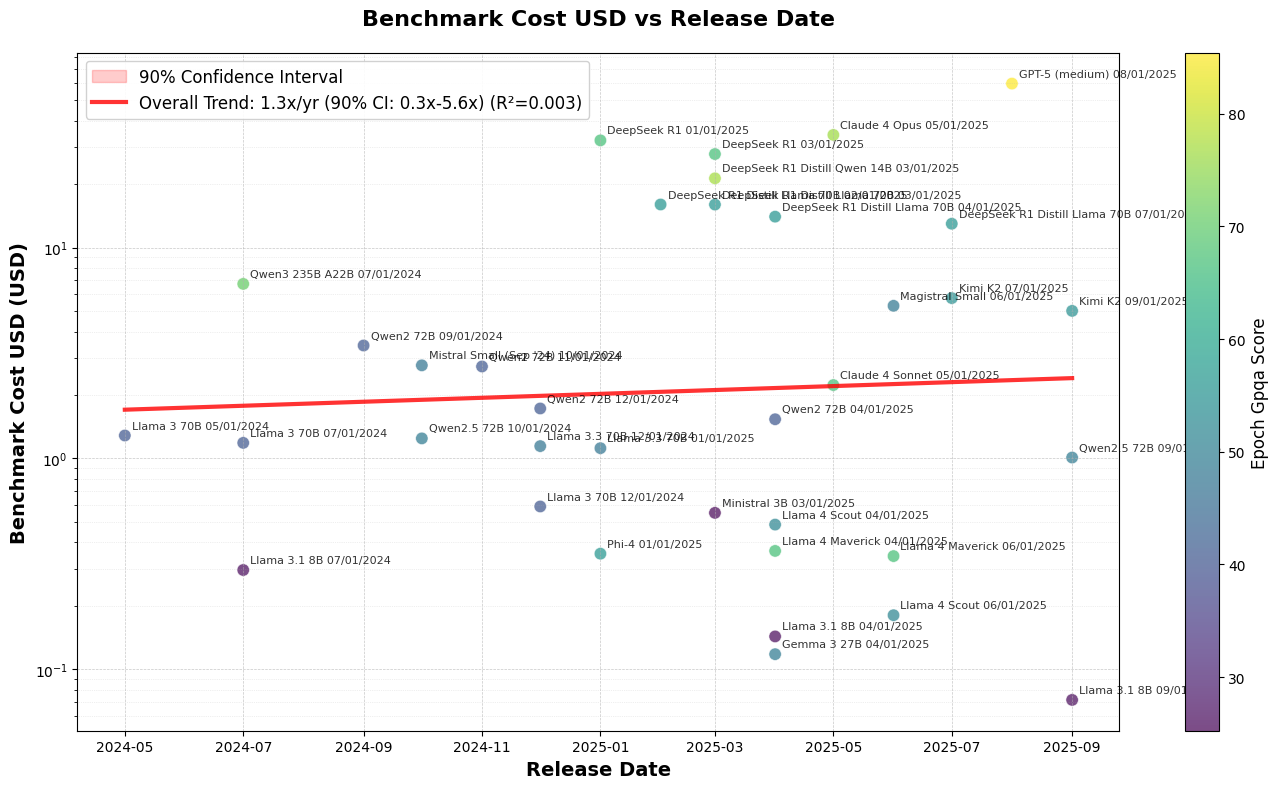


Summary Statistics:
Models analyzed: 36
Price range: $0.07 - $59.92
Epoch Gpqa range: 25.2 - 85.4
Date range: 2024-05-01 to 2025-09-01

Trend Analysis:
Annual price change: 29.4%
Price changes by factor of 1.3x each year
R² (goodness of fit): 0.003


(LinearRegression(),
                                        Model      Creator      License  \
 33                    Llama 3 70B 05/01/2024          NaN         Open   
 34                    Llama 3 70B 07/01/2024          NaN         Open   
 12                   Llama 3.1 8B 07/01/2024          NaN         Open   
 6                 Qwen3 235B A22B 07/01/2024      Alibaba         Open   
 29                      Qwen2 72B 09/01/2024          NaN         Open   
 28        Mistral Small (Sep '24) 10/01/2024          NaN         Open   
 26                    Qwen2.5 72B 10/01/2024          NaN         Open   
 30                      Qwen2 72B 11/01/2024          NaN         Open   
 22                  Llama 3.3 70B 12/01/2024          NaN         Open   
 35                    Llama 3 70B 12/01/2024          NaN         Open   
 31                      Qwen2 72B 12/01/2024          NaN         Open   
 23                  Llama 3.3 70B 01/01/2025          NaN         Open   
 15 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

def plot_benchmark_price_vs_time(
    csv_file="price_reduction_models.csv",
    price_col="Benchmark Cost USD",
    benchmark_col="epoch_gpqa", 
    min_benchmark=None,
    max_benchmark=None,
    open_license_only=False,
    include_chinese=None,
    include_reasoning_models=True,
    min_date=None,
    show_model_names=False,
    confidence_interval=True,
    fit_overall_trend=True,
    exclude_dominated=False,
    figsize=(14, 8)
):
    """
    Graph total price for any benchmark vs release date with overall fit capability.
    
    Parameters:
    - csv_file: Path to CSV file (default: "price_reduction_models.csv")
    - price_col: Price column name (default: "Benchmark Cost USD")
    - benchmark_col: Benchmark column name (default: "epoch_gpqa")
    - min_benchmark: Minimum benchmark score to include
    - max_benchmark: Maximum benchmark score to include  
    - open_license_only: If True, only include open license models
    - include_chinese: Filter for Chinese models (True/False/None)
    - include_reasoning_models: Include reasoning models (default: True)
    - min_date: Minimum date to include (datetime or string)
    - show_model_names: Show model names on points
    - confidence_interval: Show 90% confidence intervals
    - fit_overall_trend: Fit overall trend line to all data
    - exclude_dominated: Exclude Pareto dominated models
    - figsize: Figure size tuple
    
    Returns:
    - model: Fitted regression model
    - df_filtered: Filtered dataframe used for analysis
    - stats_dict: Dictionary with regression statistics
    """
    
    # Load data
    df = pd.read_csv(csv_file)
    print(f"Loaded {len(df)} models from {csv_file}")
    
    # Work on a copy
    df_work = df.copy()
    
    # 1) Clean benchmark column
    if benchmark_col in df_work.columns:
        # Handle percentage format if present
        if df_work[benchmark_col].dtype == 'object':
            df_work[benchmark_col] = (
                df_work[benchmark_col].astype(str)
                                     .str.replace('%', '', regex=False)
                                     .str.replace('nan', '')
            )
        df_work[benchmark_col] = pd.to_numeric(df_work[benchmark_col], errors='coerce')
    else:
        print(f"Warning: Benchmark column '{benchmark_col}' not found!")
        print(f"Available columns: {list(df_work.columns)}")
        return None, None, None
    
    # 2) Clean price column
    if price_col in df_work.columns:
        if df_work[price_col].dtype == 'object':
            df_work[price_col] = (
                df_work[price_col].astype(str)
                                 .str.replace('[$,]', '', regex=True)
            )
        df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    else:
        print(f"Warning: Price column '{price_col}' not found!")
        print(f"Available columns: {list(df_work.columns)}")
        return None, None, None
    
    # 3) Handle Release Date
    if 'Release Date' in df_work.columns:
        df_work['Release Date'] = pd.to_datetime(df_work['Release Date'], errors='coerce')
    else:
        print("Warning: 'Release Date' column not found!")
        return None, None, None
    
    # 4) Apply filters
    # Filter out missing data
    df_sub = df_work.dropna(subset=['Release Date', price_col, benchmark_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[benchmark_col] > 0)]
    
    # Open license filter
    if open_license_only and 'License' in df_sub.columns:
        df_sub = df_sub[
            df_sub['License'].notna() &
            df_sub['License'].str.contains('open', case=False, na=False)
        ]
    
    # Chinese models filter
    if include_chinese is not None and 'Chinese' in df_sub.columns:
        if include_chinese:
            df_sub = df_sub[df_sub['Chinese'] == True]
        else:
            df_sub = df_sub[(df_sub['Chinese'] != True) | (df_sub['Chinese'].isna())]
    
    # Reasoning models filter
    if not include_reasoning_models and 'Reasoning_TF' in df_sub.columns:
        df_sub = df_sub[(df_sub['Reasoning_TF'] != True) | (df_sub['Reasoning_TF'].isna())]
    
    # Date filter
    if min_date is not None:
        if isinstance(min_date, str):
            min_date = pd.to_datetime(min_date)
        df_sub = df_sub[df_sub['Release Date'] >= min_date]
    
    # Benchmark range filter
    if min_benchmark is not None:
        df_sub = df_sub[df_sub[benchmark_col] >= min_benchmark]
    if max_benchmark is not None:
        df_sub = df_sub[df_sub[benchmark_col] <= max_benchmark]
    
    # Exclude dominated models if requested
    if exclude_dominated:
        df_sub = df_sub.sort_values('Release Date')
        non_dominated = []
        
        for i, row in df_sub.iterrows():
            dominated = False
            for j in non_dominated:
                prev_row = df_sub.loc[j]
                # Dominated if previous model has better/equal benchmark AND lower/equal price
                if (prev_row[benchmark_col] >= row[benchmark_col] and 
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[benchmark_col] > row[benchmark_col] or prev_row[price_col] < row[price_col])):
                    dominated = True
                    break
            
            if not dominated:
                non_dominated.append(i)
        
        df_sub = df_sub.loc[non_dominated]
    
    print(f"After filtering: {len(df_sub)} models")
    
    if len(df_sub) == 0:
        print("No data points remain after filtering!")
        return None, None, None
    
    # 5) Sort by date and prepare for analysis
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # 6) Set up the plot
    plt.figure(figsize=figsize)
    
    # Create scatter plot colored by benchmark score
    scatter = plt.scatter(
        df_sub['Release Date'], 
        df_sub[price_col],
        c=df_sub[benchmark_col], 
        cmap='viridis', 
        alpha=0.7,
        s=80,
        edgecolors='white',
        linewidth=0.5
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    benchmark_name = benchmark_col.replace('_', ' ').title()
    cbar.set_label(f'{benchmark_name} Score', fontsize=12)
    
    # 7) Fit overall trend if requested
    if fit_overall_trend and len(df_sub) >= 3:
        # Prepare data for regression
        X = df_sub['Date_Ordinal'].values.reshape(-1, 1)
        y_log = np.log(df_sub[price_col].values)
        
        # Fit linear regression on log scale
        model = LinearRegression().fit(X, y_log)
        
        # Calculate R²
        r2 = model.score(X, y_log)
        
        # Calculate annual change
        slope = model.coef_[0]
        annual_log_change = slope * 365
        annual_pct_change = (np.exp(annual_log_change) - 1) * 100
        factor_change_per_year = np.exp(annual_log_change)
        
        # Express as factor decrease if decreasing
        if factor_change_per_year < 1:
            factor_decrease_per_year = 1 / factor_change_per_year
        else:
            factor_decrease_per_year = None
        
        # Generate prediction line
        min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
        x_range = np.arange(min_ord, max_ord + 1)
        x_dates = [datetime.fromordinal(int(d)) for d in x_range]
        y_pred_log = model.predict(x_range.reshape(-1, 1))
        
        # Calculate confidence intervals if requested
        if confidence_interval and len(df_sub) > 2:
            n = len(df_sub)
            residuals = y_log - model.predict(X)
            mse = np.sum(residuals**2) / (n - 2)
            se = np.sqrt(mse / np.sum((X.flatten() - np.mean(X))**2))
            
            # t-value for 90% confidence interval
            t_val = stats.t.ppf(0.95, n - 2)
            
            # Confidence interval for slope
            ci_lower = slope - t_val * se
            ci_upper = slope + t_val * se
            
            # Plot confidence interval
            y_lower = ci_lower * x_range + model.intercept_
            y_upper = ci_upper * x_range + model.intercept_
            
            plt.fill_between(
                x_dates,
                np.exp(y_lower),
                np.exp(y_upper),
                alpha=0.2,
                color='red',
                label='90% Confidence Interval'
            )
            
            # CI for annual factors
            annual_factor_lower = 1 / np.exp(ci_upper * 365) if factor_decrease_per_year else np.exp(ci_lower * 365)
            annual_factor_upper = 1 / np.exp(ci_lower * 365) if factor_decrease_per_year else np.exp(ci_upper * 365)
            ci_text = f" (90% CI: {annual_factor_lower:.1f}x-{annual_factor_upper:.1f}x)"
        else:
            ci_text = ""
        
        # Plot trend line
        if factor_decrease_per_year:
            trend_label = f'Overall Trend: {factor_decrease_per_year:.1f}x cheaper/yr{ci_text} (R²={r2:.3f})'
        else:
            trend_label = f'Overall Trend: {factor_change_per_year:.1f}x/yr{ci_text} (R²={r2:.3f})'
        
        plt.plot(
            x_dates, 
            np.exp(y_pred_log), 
            'r-', 
            linewidth=3,
            alpha=0.8,
            label=trend_label
        )
        
        # Store statistics
        stats_dict = {
            'slope': slope,
            'annual_pct_change': annual_pct_change,
            'factor_change_per_year': factor_change_per_year,
            'factor_decrease_per_year': factor_decrease_per_year,
            'r2': r2,
            'n_points': len(df_sub)
        }
    else:
        model = None
        stats_dict = None
    
    # 8) Add model names if requested
    if show_model_names and 'Model' in df_sub.columns:
        for idx, row in df_sub.iterrows():
            plt.annotate(
                row['Model'], 
                (row['Release Date'], row[price_col]),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8,
                alpha=0.8
            )
    
    # 9) Format the plot
    plt.yscale('log')
    plt.xlabel('Release Date', fontsize=14, fontweight='bold')
    plt.ylabel(f'{price_col.replace("_", " ")} (USD)', fontsize=14, fontweight='bold')
    
    # Create title
    filter_parts = []
    if open_license_only:
        filter_parts.append("open-license only")
    if include_chinese is True:
        filter_parts.append("Chinese models")
    elif include_chinese is False:
        filter_parts.append("non-Chinese models")
    if not include_reasoning_models:
        filter_parts.append("non-reasoning models")
    if exclude_dominated:
        filter_parts.append("non-dominated only")
    
    filter_text = f" ({', '.join(filter_parts)})" if filter_parts else ""
    
    benchmark_range = ""
    if min_benchmark is not None or max_benchmark is not None:
        min_val = min_benchmark if min_benchmark is not None else "min"
        max_val = max_benchmark if max_benchmark is not None else "max"
        benchmark_range = f" | {benchmark_name}: [{min_val}, {max_val}]"
    
    plt.title(f'{price_col.replace("_", " ")} vs Release Date{filter_text}{benchmark_range}', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Grid and legend
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)
    
    if fit_overall_trend:
        plt.legend(fontsize=12, loc='best', framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
    
    # 10) Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"Models analyzed: {len(df_sub)}")
    print(f"Price range: ${df_sub[price_col].min():.2f} - ${df_sub[price_col].max():.2f}")
    print(f"{benchmark_name} range: {df_sub[benchmark_col].min():.1f} - {df_sub[benchmark_col].max():.1f}")
    print(f"Date range: {df_sub['Release Date'].min().strftime('%Y-%m-%d')} to {df_sub['Release Date'].max().strftime('%Y-%m-%d')}")
    
    if stats_dict:
        print(f"\nTrend Analysis:")
        print(f"Annual price change: {stats_dict['annual_pct_change']:.1f}%")
        if stats_dict['factor_decrease_per_year']:
            print(f"Price becomes {stats_dict['factor_decrease_per_year']:.1f}x cheaper each year")
        else:
            print(f"Price changes by factor of {stats_dict['factor_change_per_year']:.1f}x each year")
        print(f"R² (goodness of fit): {stats_dict['r2']:.3f}")
    
    return model, df_sub, stats_dict

# Example usage for GPQA:
plot_benchmark_price_vs_time(
    price_col="Benchmark Cost USD",
    benchmark_col="epoch_gpqa", 
    open_license_only=False,
    min_date="2024-01-01",
    confidence_interval=True,
    fit_overall_trend=True,
    show_model_names=True
)